## Data Loading and Processing
`scikit-image`: For image io and transforms  
`pandas`: For easier csv parsing  

`reference` `https://pytorch.org/tutorials/beginner/data_loading_tutorial.html`

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

# interactive mode
plt.ion()

In [2]:
face_landmarks = pd.read_csv('data/faces/face_landmarks.csv')

image_name = face_landmarks.iloc[29, 0]
landmarks = face_landmarks.iloc[29, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

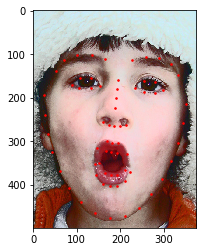

In [3]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(.001)

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', image_name)), landmarks)
plt.show()

### Dataset class
`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:  

* `__len__` so that `len(dataset)` returns the size of the dataset  

* `__getitem__` to support the indexing such that `dataset[i]` can be used to get i-th sample

In [4]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, index):
        image_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[index, 0])
        image = io.imread(image_name)
        
        landmarks = self.landmarks_frame.iloc[index, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

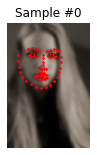

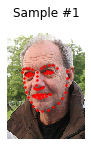

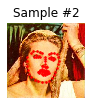

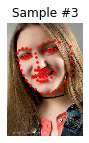

In [5]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                   root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    # **kwargs
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

### Transforms
One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some preprocessing code.  
* `Rescale`: to scale the image
* `RandomCrop`: to crop from image randomly (data augmentation)
* `ToTensor`: to convert the numpy images to torch images


In [10]:
from skimage.transform import resize

In [16]:
class Rescale(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        image = resize(image, (new_h, new_w))
        
        # x and y
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image':image, 'landmarks':landmarks}

class RandomCrop(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size)==2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top : top + new_h,
                      left : left + new_w]
        
        landmarks = landmarks - [left, top]
        
        return {'image':image, 'landmarks':landmarks}
    
class ToTensor(object):
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # numpy image : H x W x C
        # torch image : C x H x W
        image = image.transpose(2, 0, 1)
        
        return {'image':torch.from_numpy(image),
                'landmarks':torch.from_numpy(landmarks)}

### Compose transforms
`torchvision.transforms.Compose` is a simple callable class which allows us to compose transforms

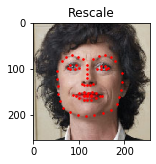

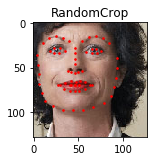

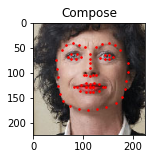

In [19]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]
for i, transform in enumerate([scale, crop, composed]):
    transformed_sample = transform(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(transform).__name__)
    show_landmarks(**transformed_sample)
    
plt.show()

In [20]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/',
                                    transform=transforms.Compose([
                                        Rescale(256),
                                        RandomCrop(224),
                                        ToTensor()
                                    ]))

### DataLoader
* Batching the data
* Shuffling the data
* Load the data in parallel using `multiprocessing` workers

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


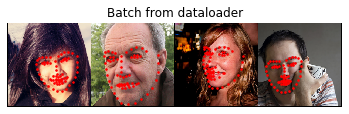

In [25]:
dataloader = DataLoader(face_dataset, batch_size=4, shuffle=True, num_workers=0)

def show_landmarks_batch(sample_batch):
    images_batch, landmarks_batch = sample_batch['image'], sample_batch['landmarks']
    
    batch_size = len(images_batch)
    image_size = images_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    
    for i in range(batch_size):
        plt.scatter(
            landmarks_batch[i, :, 0].numpy() + i * image_size + (i+1) * grid_border_size,
            landmarks_batch[i, :, 1].numpy() + grid_border_size,
            s = 10, marker='.', c='r'
        )
        
        plt.title('Batch from dataloader')

for i, sample_batch in enumerate(dataloader):
    print(i, sample_batch['image'].size(), sample_batch['landmarks'].size())
    
    if i == 2:
        plt.figure()
        show_landmarks_batch(sample_batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break